<h1 style="text-align:center;background-color:#0e4b90;color:white">UNET za segmentaciju tela</h1><br>

# Učitavanje biblioteka

In [77]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [78]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input,Dropout,UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [79]:
# putanje do foldera gde se nalaze nase slike
imgs_dir = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images'
masks_dir = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks'
backgrounds = '/kaggle/input/segmentation-backgrounds/back_za_projekat'

# Učitavanje podataka

In [80]:
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = np.float32)
backs_arr = np.zeros((len(os.listdir(backgrounds)), 256, 256, 3), dtype = np.float32)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = np.float32)


for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    
for index in range(len(os.listdir(backgrounds))):
    img = load_img(os.path.join(backgrounds, os.listdir(backgrounds)[index]), target_size = (256, 256, 3))
    backs_arr[index] = img_to_array(img)
    


for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, os.listdir(masks_dir)[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)


imgs_arr /= 255.
backs_arr /= 255.
masks_arr /= 255.

x_train = imgs_arr[10:]
y_train = masks_arr[10:]

x_test = imgs_arr[0:10]
y_test = masks_arr[0:10]

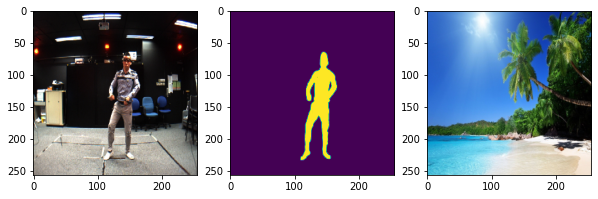

In [81]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,3, 1)
plt.imshow(imgs_arr[0])
f.add_subplot(1,3, 2)
plt.imshow(masks_arr[0])
f.add_subplot(1,3,3)
plt.imshow(backs_arr[0])
plt.show(block=True)

<h1 style="text-align:center;background-color:#0e4b90;color:white">UNET model</h1><br>

<p style="text-align:center">Pre nego što budemo pričali o UNET-u, hajde da razumemo šta je zadatak ovog modela.<br>
Za razliku od klasične klasifikacije gde predviđamo klasu za celu sliku, u semantičkoj segmentaciji želimo da predvidimo klasu za svaki pojedinačni piksel <br>
(u ovom slučaju da li je to ljudsko telo ili samo pozadina, što je binarna klasifikacija). Ova tehnika se takođe koristi za zadatak autonomne vožnje gde naš algoritam <br>
klasifikuje da li pikseli pripadaju automobilima, ljudima, semaforima, saobraćajnim znakovima, itd. <br>
Dakle, kako da napravimo ovaj model? Jedan od modela koji se pokazao kao dobar za ovaj zadatak je UNET</p>
<div style="text-align:center"><img src="https://camo.githubusercontent.com/d55a437337d0e08c6a082714959253d80b81ce4e6c18e94688d9aff16e3bf2f8/68747470733a2f2f6c6d622e696e666f726d6174696b2e756e692d66726569627572672e64652f70656f706c652f726f6e6e656265722f752d6e65742f752d6e65742d6172636869746563747572652e706e67"/ style="width:600px;height:400px;"></div><br><br>
<p style="text-align:center">Unet ima dva dela u svojoj arhitekturi. Prvi deo je sažimajući deo (koder), a drugi deo je prosiravajuci deo(dekoder)<br>
U koderu imamo standardnu arhitekturu poput cnn-a sa dva Conv2D sloja praćena MaxPool-om (osim u sloju uskog grla (5. cnn sloj))<br>
U dekoderu imamo transponovanu konvoluciju sa korakom(stride) od 2 i 'same' dopunom koji će udvostručiti dimenzije naše ulazne slike.<br>
Nakon te transponovane konvolucije, spojićemo njen izlaz sa izlazom odgovarajućeg konvolucionog sloja u koderu.<br>
Ovu konkatenaciju smo uradili tako da naš dekoder znao o reprezentacijama karakteristika koje proizvode naši konvolucioni slojevi, što će nam pomoći da lakše klasifikujemo piksle slike.<br><br>
Pa hajde da ga izgradimo! (Ova implementacija nije ista kao u originalnom papiru. Dodao sam grupnu normalizaciju(batch normalization) i leakyReLU i koristio sam same padding umesto valid paddinga).</p>

In [82]:
def conv_block(inputs,filters,max_pool=True):
    conv1 = Conv2D(filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    bn1 = BatchNormalization()(conv1)
    ac1 = LeakyReLU(0.2)(bn1)
    conv2 = Conv2D(filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(ac1)
    bn2 = BatchNormalization()(conv2)
    ac2 = LeakyReLU(0.2)(bn2)
    skip = ac2
    if max_pool:
        mp = MaxPool2D()(ac2)
        next_layer_input = mp
    else:
        next_layer_input = ac2
    
    return next_layer_input, skip

def up_block(inputs,skip_inputs,filters):
    trans_conv1 = Conv2DTranspose(filters,3,2,padding='same')(inputs)
    x = concatenate([trans_conv1,skip_inputs],axis=3)
    b = conv_block(x,filters,max_pool=False)
    return b[0]

In [83]:
def unet_from_scratch(input_size=(256,256,3),number_of_classes=1,final_activation='sigmoid'):
    inputs = Input(shape=input_size)
    conv1 = conv_block(inputs,32)
    conv2 = conv_block(conv1[0],64)
    conv3 = conv_block(conv2[0],128)
    conv4 = conv_block(conv3[0],256)
    conv5 = conv_block(conv4[0],512,max_pool=False)
    up1 = up_block(conv5[0],conv4[1],256)
    up2 = up_block(up1,conv3[1],128)
    up3 = up_block(up2,conv2[1],64)
    up4 = up_block(up3,conv1[1],32)
    
    conv6 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv6)
    leaky = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation=final_activation)(leaky)
    unet = Model(inputs=inputs,outputs=outputs)
    return unet

<h1 style="text-align:center;background-color:#0e4b90;color:white">Funkcija gubitka</h1><br>
<p style="text-align:center">U segmentaciji, korišćenje tačnosti(accuracy) za metriku evaluacije modela nije dobra ideja. Zašto?<br>
Pa, uzmimo hipotetički slučaj gde pokušavamo da segmentišemo jako male objekte na slici i recimo da oni zauzimaju oko 3% piksela u celoj slici.<br>
Ako predvidimo da slika nema nijedan od ovih malih objekata (maska puna 0), tačnost našeg modela će biti 97% što nije dobar prikaz stvarnih performansi našeg modela.<br>Ali postoji još jedna metrika koja nam pomaže u rešavanju ovog problema, a zove se IoU (Intersection over Union).</p><br><br>
<div style="text-align:center"><img src="https://miro.medium.com/max/1838/0*nm8gO9HZoLU7IES2" style="width:600px;height:400px;"></div><br><br>
<p style="text-align:center">IoU, takođe poznat kao Jaccardov koeficijent sličnosti, je statistika koja se koristi za merenje sličnosti i raznolikosti skupova uzoraka.<br>
Što je presek veći, to je precizniji izlaz. Na presek možemo gledati kao na istinski pozitivan rezultat (predvidjeli smo klasu piksela koja zaista jeste),<br>
a delovi koji se ne preklapaju kao lažno negativne i lažno pozitivne<br>
Iz ovoga možemo da izgradimo bolju metriku za procenu našeg modela, a takođe i kreiramo funkciju gubitka koju će naš model pokušati da minimizuje (tj da maksimizuje IoU).<br> Ovaj gubitak je poznat kao Jaccard-ov gubitak.</p>

In [84]:
# definicija funkcije gubitka
from keras import backend as K
def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)
def jaccard_loss(y_true,y_pred,smooth=1):
    return -jaccard_coef(y_true,y_pred,smooth)

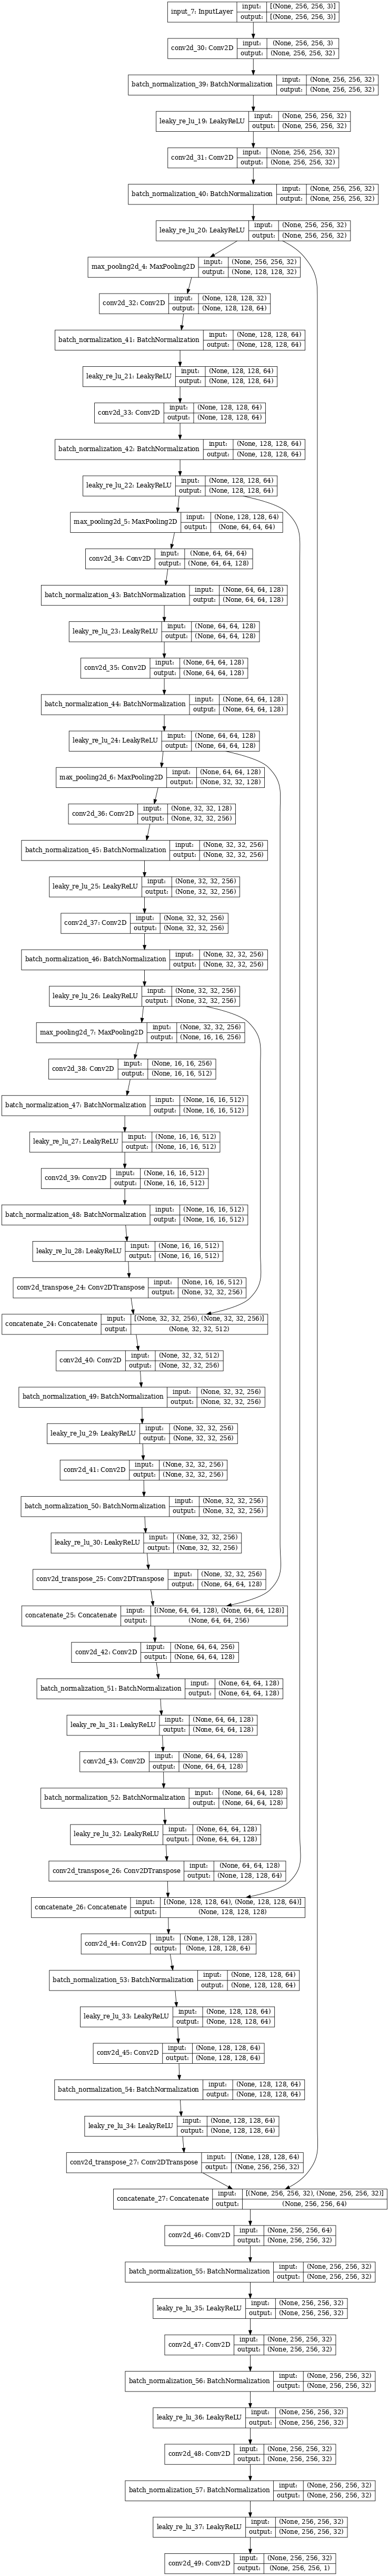

In [85]:
model = unet_from_scratch()

# plotovanje naseg modela
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [86]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 256, 256, 32) 128         conv2d_30[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_19 (LeakyReLU)      (None, 256, 256, 32) 0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

In [87]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])

In [88]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
30/30 [==============================] - 19s 494ms/step - loss: -0.1268 - jaccard_coef: 0.1276 - val_loss: -0.0433 - val_jaccard_coef: 0.0433
Epoch 2/20
30/30 [==============================] - 12s 399ms/step - loss: -0.2058 - jaccard_coef: 0.2064 - val_loss: -0.0480 - val_jaccard_coef: 0.0481
Epoch 3/20
30/30 [==============================] - 12s 412ms/step - loss: -0.2958 - jaccard_coef: 0.2958 - val_loss: -0.0471 - val_jaccard_coef: 0.0471
Epoch 4/20
30/30 [==============================] - 12s 412ms/step - loss: -0.4271 - jaccard_coef: 0.4282 - val_loss: -0.0834 - val_jaccard_coef: 0.0834
Epoch 5/20
30/30 [==============================] - 12s 412ms/step - loss: -0.5749 - jaccard_coef: 0.5757 - val_loss: -0.1242 - val_jaccard_coef: 0.1243
Epoch 6/20
30/30 [==============================] - 12s 397ms/step - loss: -0.7055 - jaccard_coef: 0.7065 - val_loss: -0.1784 - val_jaccard_coef: 0.1791
Epoch 7/20
30/30 [==============================] - 12s 412ms/step - loss: -0.7829

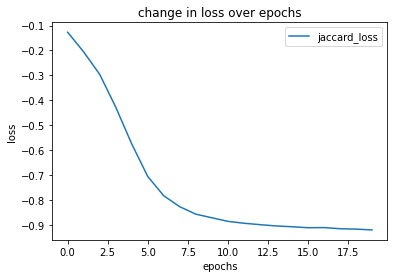

In [89]:
# Plotovanje promene funkcije gubitka u periodu od 20 epoha
x = [i for i in range(20)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [90]:
predictions = model.predict(x_test)

# Pomoćne funkcije

In [91]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.6] = 1
    return mask

def create_inverted_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions<0.6] = 1
    return mask

In [92]:
def plot_results_for_one_sample(predictions,sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index])
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(mask)
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

In [93]:
def plot_background_change(predictions,sample_index,background_index):
    mask_inverted = create_inverted_mask(predictions[sample_index])
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,3,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,3,2)
    plt.title('Input backgound')
    plt.imshow(backs_arr[background_index])
    f.add_subplot(1,3,3)
    plt.title('Swaped background')
    plt.imshow((backs_arr[background_index]*mask_inverted) + x_test[sample_index]*mask)

# Plotovanje rezultata treniranja

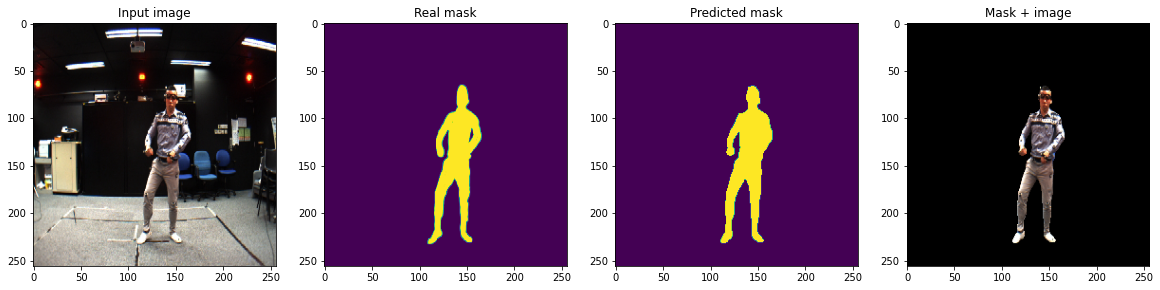

In [94]:
plot_results_for_one_sample(predictions,0)

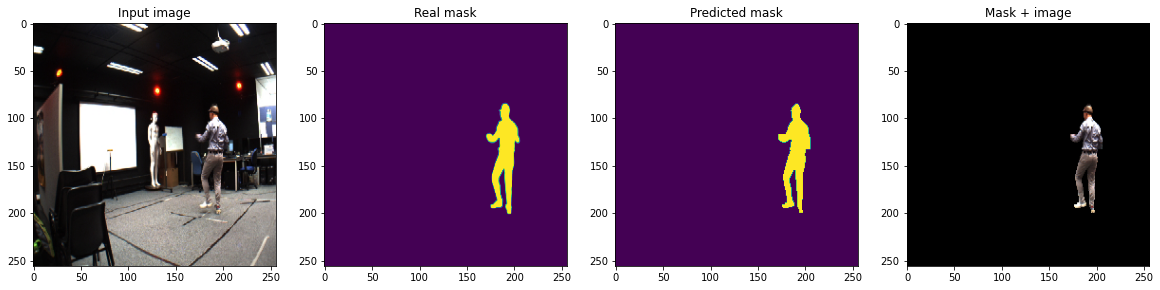

In [95]:
plot_results_for_one_sample(predictions,1)

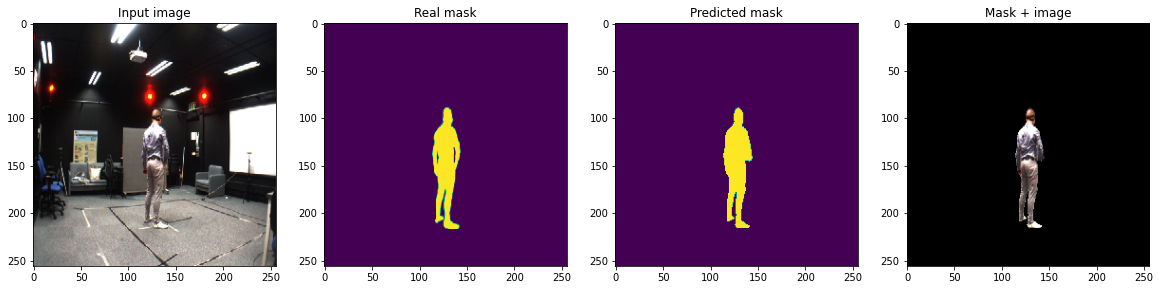

In [96]:
plot_results_for_one_sample(predictions,2)

# Prikazivanje jednog slučaja korišćenja ovog modela: Promena pozadina

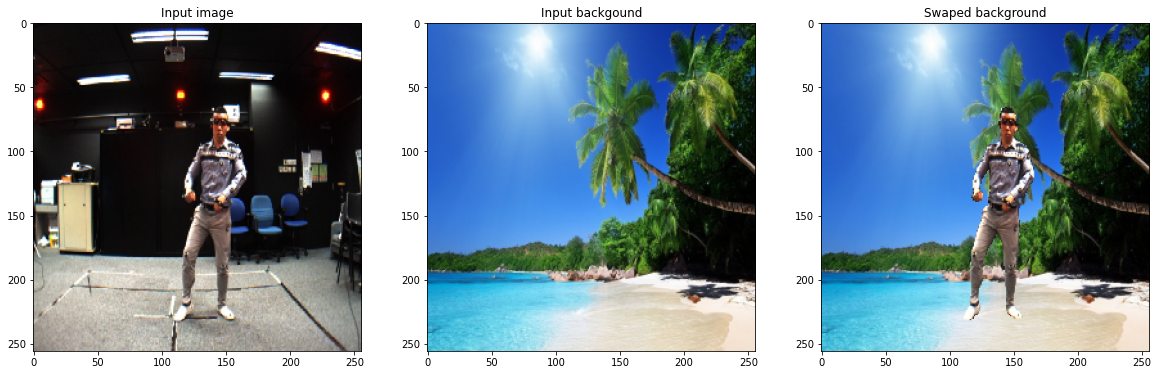

In [97]:
plot_background_change(predictions,0,0)

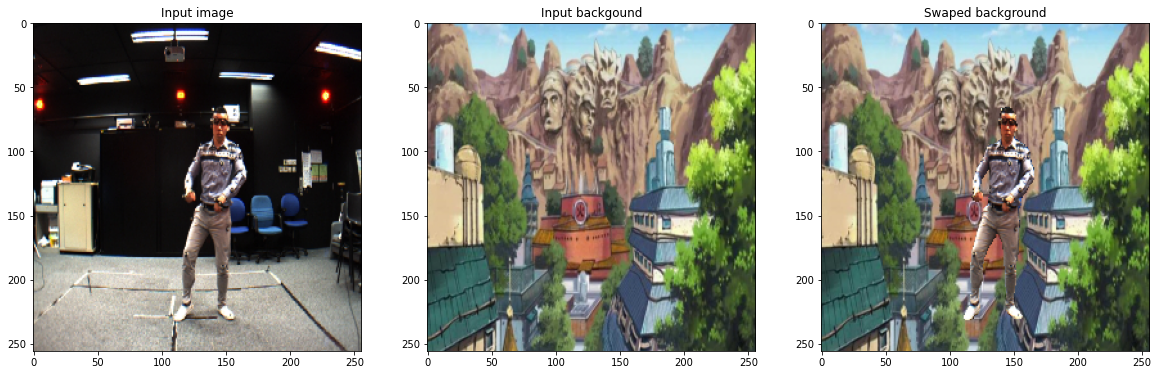

In [98]:
plot_background_change(predictions,0,1)

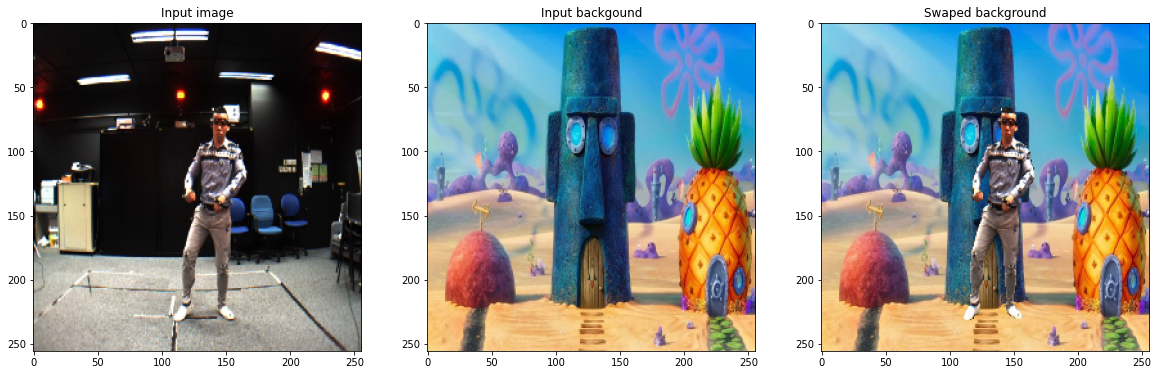

In [99]:
plot_background_change(predictions,0,2)

In [100]:
!pip install -q git+https://github.com/tensorflow/examples.git

# UNET model napravljen koristeći već istrenirane arhitekture. Koristićemo VGG16 za koder i PIX2PIX upsamle slojeve za dekoder

In [101]:
def unet_pretrained(input_shape=(256,256,3),number_of_classes = 1,final_activation='sigmoid'):
    # Load vgg16 model
    encoder = tf.keras.applications.vgg16.VGG16(
        include_top=False,weights='imagenet',
        input_shape=(256,256,3)
    )
    # Freeze layers
    for layer in encoder.layers:
        layer.trainable = False

    # Load pix2pix upsampling layers    
    from tensorflow_examples.models.pix2pix import pix2pix
    decoder = [
        pix2pix.upsample(512, 3),  
        pix2pix.upsample(256, 3),  
        pix2pix.upsample(128, 3),  
        pix2pix.upsample(64, 3),   
    ]
    skip1 = encoder.layers[2].output
    skip2 = encoder.layers[5].output
    skip3 = encoder.layers[9].output
    skip4 = encoder.layers[13].output
    
    x = encoder.layers[17].output
    x = decoder[0](x)
    x = concatenate([x,skip4],axis=3)
    x = decoder[1](x)
    x = concatenate([x,skip3],axis=3)
    x = decoder[2](x)
    x = concatenate([x,skip2],axis=3)
    x = decoder[3](x)
    x = concatenate([x,skip1],axis=3)
    
    x = Conv2D(32,3,padding='same',kernel_initializer='he_normal',activation='relu')(x)
    output = Conv2D(number_of_classes,1,padding='same',activation=final_activation)(x)
    model = Model(inputs=encoder.input,outputs=output)
    return model

In [102]:
model1 = unet_pretrained()

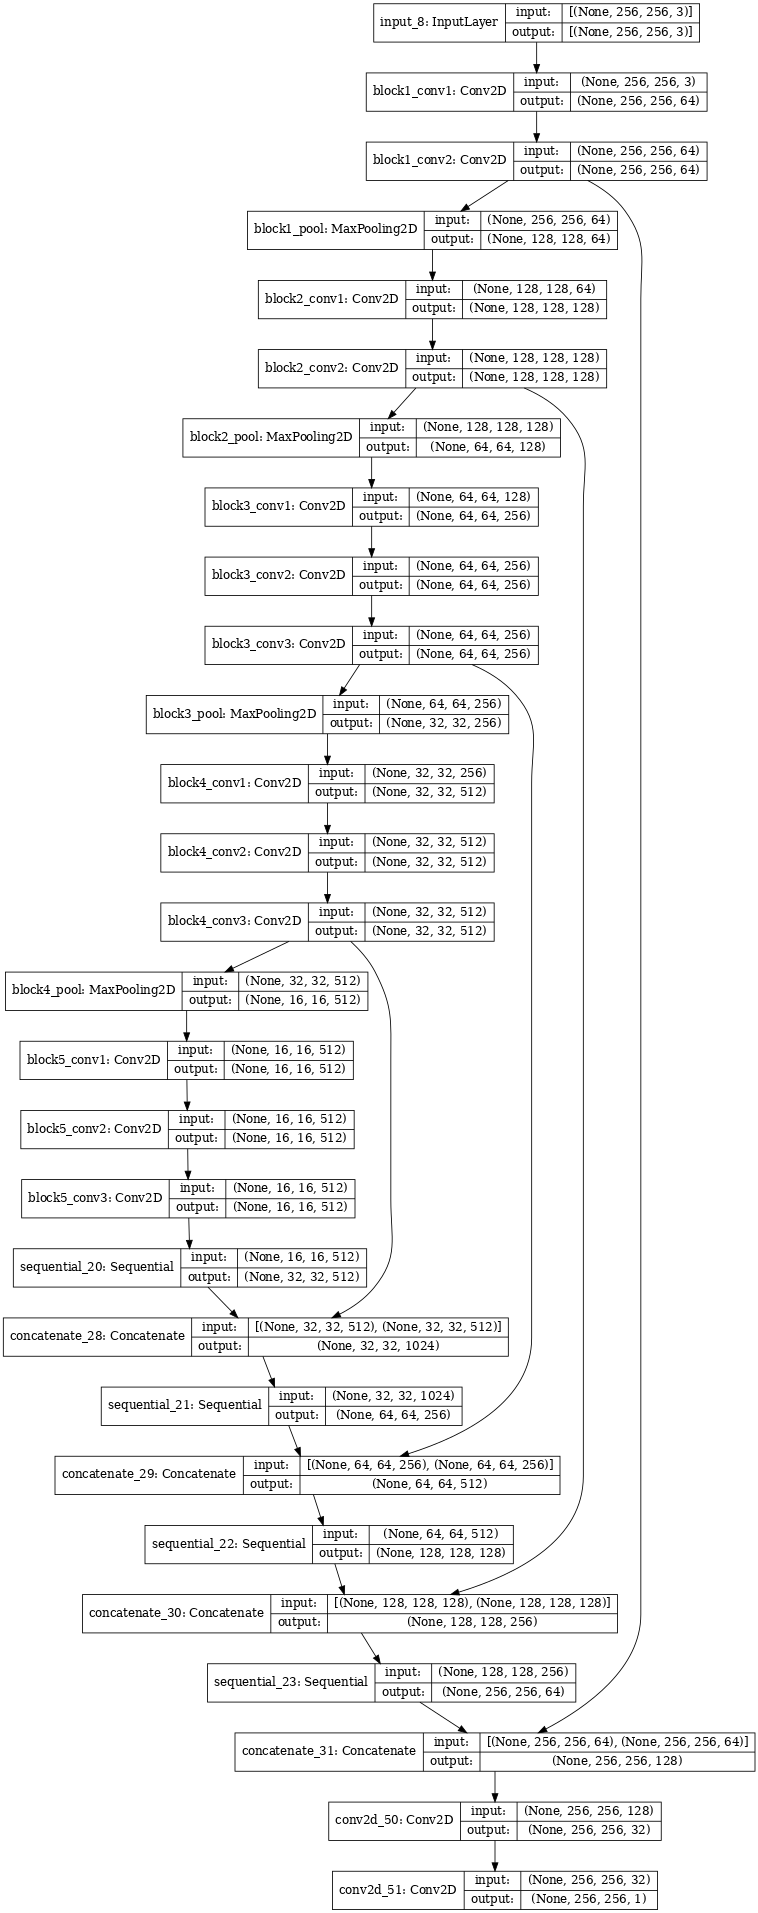

In [103]:
keras.utils.plot_model(
    model1,
    to_file="model1.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [104]:
model1.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [105]:
model1.compile(optimizer=keras.optimizers.Adam(1e-3),loss = [jaccard_loss],metrics=[jaccard_coef])

In [106]:
history1 = model1.fit(x_train,y_train,batch_size=32,validation_split=0.2,epochs=20)

Epoch 1/20
30/30 [==============================] - 28s 734ms/step - loss: -0.4321 - jaccard_coef: 0.4373 - val_loss: -0.2225 - val_jaccard_coef: 0.2222
Epoch 2/20
30/30 [==============================] - 15s 515ms/step - loss: -0.8131 - jaccard_coef: 0.8134 - val_loss: -0.3508 - val_jaccard_coef: 0.3500
Epoch 3/20
30/30 [==============================] - 14s 477ms/step - loss: -0.8553 - jaccard_coef: 0.8555 - val_loss: -0.7828 - val_jaccard_coef: 0.7813
Epoch 4/20
30/30 [==============================] - 15s 516ms/step - loss: -0.8754 - jaccard_coef: 0.8753 - val_loss: -0.8738 - val_jaccard_coef: 0.8730
Epoch 5/20
30/30 [==============================] - 15s 516ms/step - loss: -0.8888 - jaccard_coef: 0.8887 - val_loss: -0.8786 - val_jaccard_coef: 0.8776
Epoch 6/20
30/30 [==============================] - 14s 476ms/step - loss: -0.8997 - jaccard_coef: 0.8997 - val_loss: -0.8899 - val_jaccard_coef: 0.8894
Epoch 7/20
30/30 [==============================] - 15s 517ms/step - loss: -0.9054

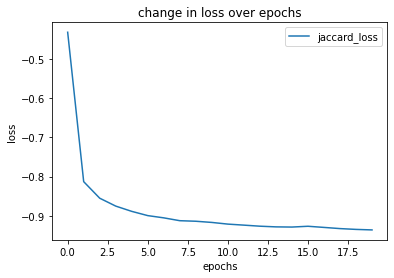

In [107]:
# Plotovanje promene funkcije gubitka u periodu od 20 epoha
x = [i for i in range(20)]
plt.plot(x,history1.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [108]:
predictions1 = model1.predict(x_test)

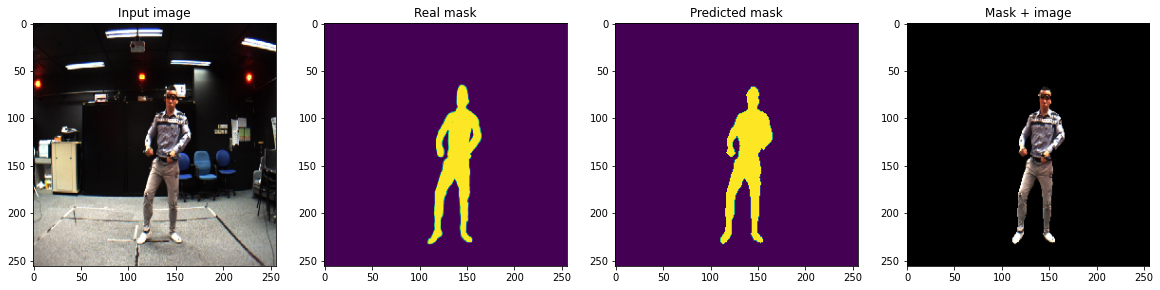

In [109]:
plot_results_for_one_sample(predictions1,0)

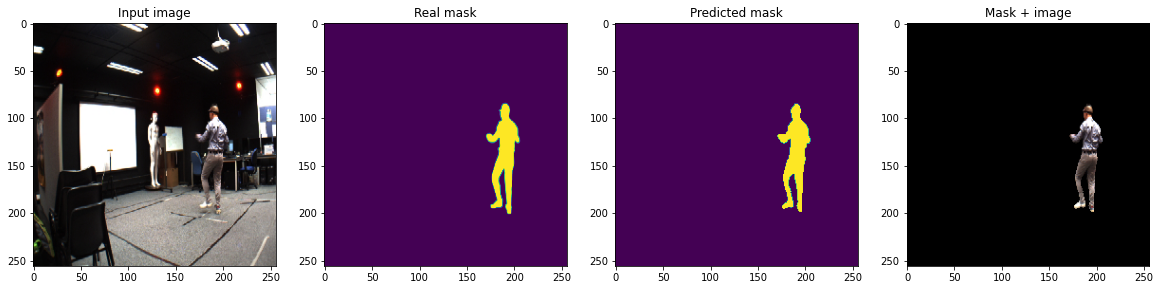

In [110]:
plot_results_for_one_sample(predictions1,1)

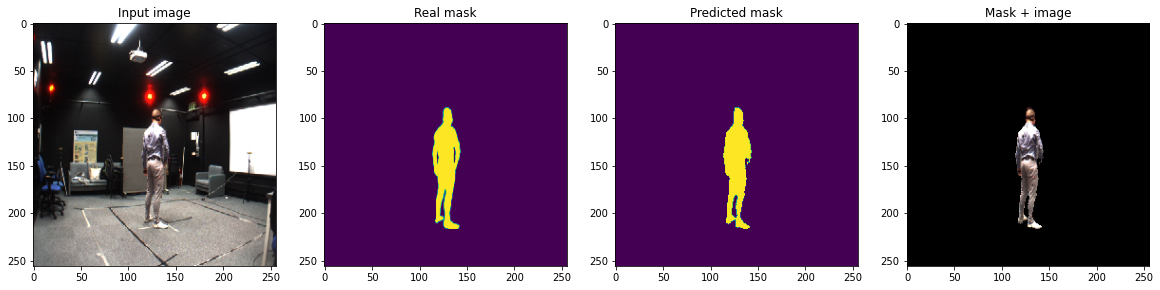

In [111]:
plot_results_for_one_sample(predictions1,2)

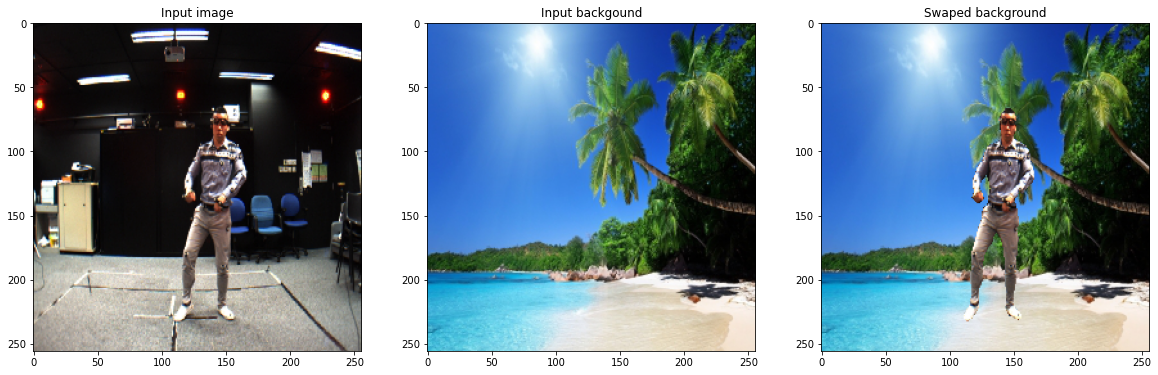

In [112]:
plot_background_change(predictions1,0,0)

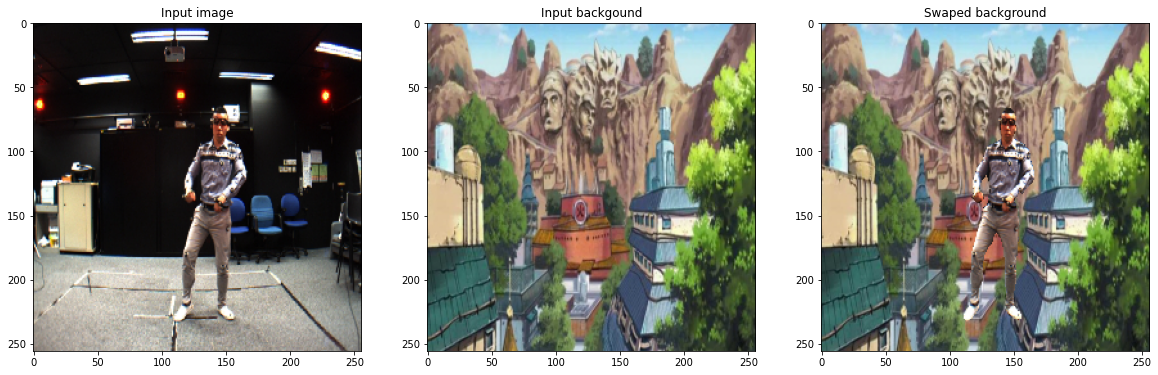

In [113]:
plot_background_change(predictions1,0,1)

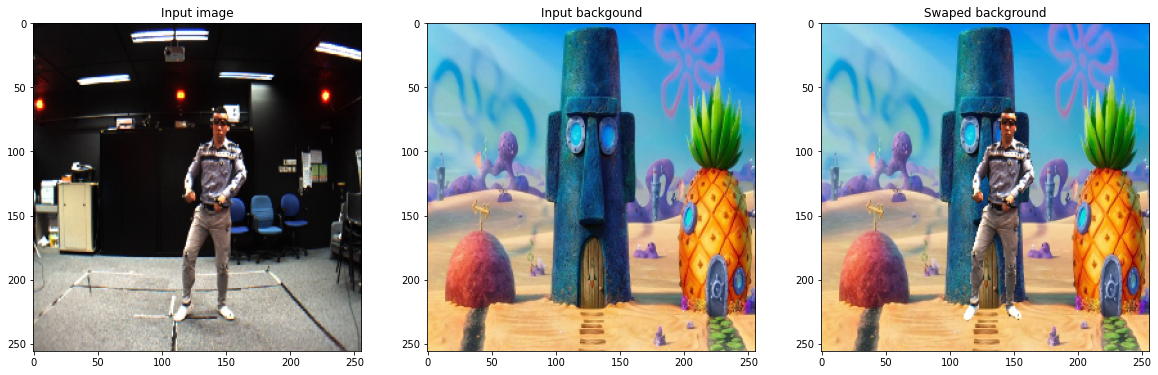

In [114]:
plot_background_change(predictions1,0,2)

In [115]:
tf.keras.backend.clear_session()

In [116]:
bacteria_images_path = "../input/bacteria-detection-with-darkfield-microscopy/images"
bacteria_masks_path = "../input/bacteria-detection-with-darkfield-microscopy/masks"

In [117]:
imgs = np.zeros((len(os.listdir(bacteria_images_path)), 256, 256, 3), dtype = np.float32)
masks = np.zeros((len(os.listdir(bacteria_images_path)), 256, 256, 3), dtype = np.float32)

for index in range(len(os.listdir(bacteria_images_path))):
    img = load_img(os.path.join(bacteria_images_path, os.listdir(bacteria_images_path)[index]), target_size = (256, 256, 3))
    img = img_to_array(img)
    img /= 255.
    imgs[index] = img
    
for index in range(len(os.listdir(bacteria_masks_path))):
    mask = load_img(os.path.join(bacteria_masks_path,os.listdir(bacteria_masks_path)[index]),target_size=(256,256,1),color_mode='grayscale')
    mask = img_to_array(mask)
    mask = tf.keras.utils.to_categorical(mask,3)
    masks[index] = mask



In [118]:
x_train = imgs[0:320]
y_train= masks[0:320]


x_valid = imgs[320:343]
y_valid = masks[320:343]


x_test = imgs[343:367]
y_test = masks[343:367]


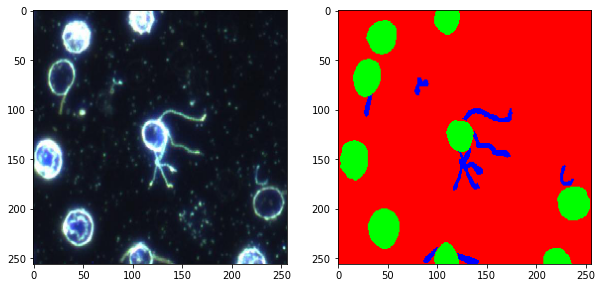

In [119]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(x_train[1])
f.add_subplot(1,2, 2)
plt.imshow(y_train[1])


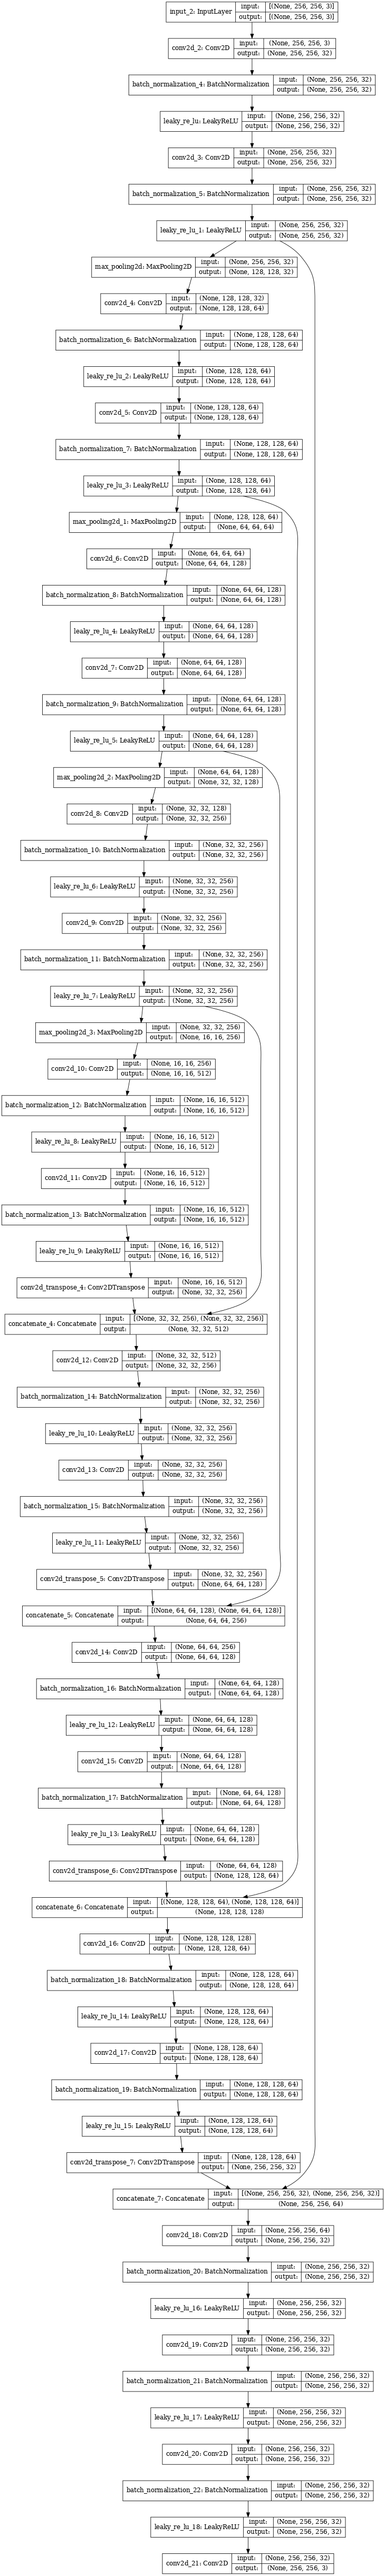

In [169]:
model = unet_from_scratch(number_of_classes=3,final_activation='softmax')
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [170]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience=20)
plat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=10,factor = 0.00001)


In [171]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss = [jaccard_loss],metrics=[jaccard_coef])

In [172]:
history = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=100,batch_size=16,callbacks=[early_stop,plat])

Epoch 1/100
20/20 [==============================] - 6s 227ms/step - loss: -0.3919 - jaccard_coef: 0.3919 - val_loss: -0.0850 - val_jaccard_coef: 0.0837
Epoch 2/100
20/20 [==============================] - 4s 200ms/step - loss: -0.5408 - jaccard_coef: 0.5408 - val_loss: -0.0849 - val_jaccard_coef: 0.0836
Epoch 3/100
20/20 [==============================] - 4s 198ms/step - loss: -0.6203 - jaccard_coef: 0.6203 - val_loss: -0.0929 - val_jaccard_coef: 0.0909
Epoch 4/100
20/20 [==============================] - 4s 200ms/step - loss: -0.6992 - jaccard_coef: 0.6992 - val_loss: -0.1907 - val_jaccard_coef: 0.1877
Epoch 5/100
20/20 [==============================] - 4s 199ms/step - loss: -0.7607 - jaccard_coef: 0.7607 - val_loss: -0.3700 - val_jaccard_coef: 0.3835
Epoch 6/100
20/20 [==============================] - 4s 200ms/step - loss: -0.8088 - jaccard_coef: 0.8088 - val_loss: -0.7042 - val_jaccard_coef: 0.6978
Epoch 7/100
20/20 [==============================] - 4s 199ms/step - loss: -0.8326

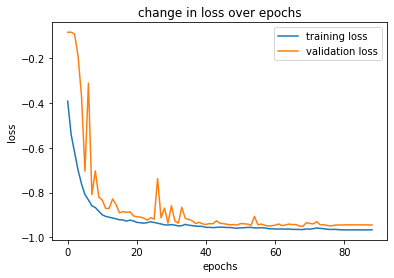

In [173]:
x = [i for i in range(len(history.history['loss']))]
plt.plot(x,history.history['loss'])
plt.plot(x,history.history['val_loss'])
plt.title('change in loss over epochs')
plt.legend(['training loss','validation loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

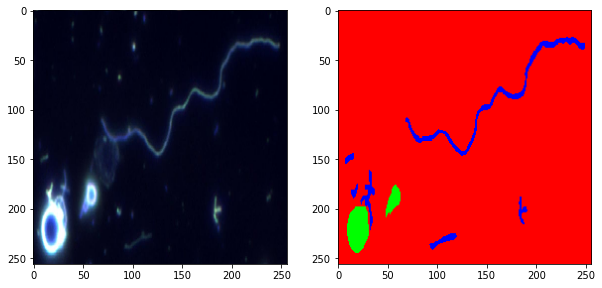

In [202]:
test_img = x_test[10]
test_mask = y_test[10]


f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(test_img)
f.add_subplot(1,2, 2)
plt.imshow(test_mask)

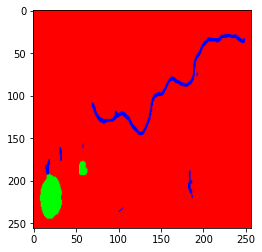

In [203]:
prediction = model.predict(tf.expand_dims(test_img,axis=0))

plt.imshow(tf.squeeze(prediction))

In [201]:
def plot_results(input_image,input_mask,output_mask):
    f = plt.figure(figsize=(10,10))
    f.add_subplot(1,3, 1)
    plt.title('Input image')
    plt.imshow(input_image)
    f.add_subplot(1,3, 2)
    plt.title('Input mask')
    plt.imshow(input_mask)
    f.add_subplot(1,3, 3)
    plt.title('Output mask')
    plt.imshow(output_mask)

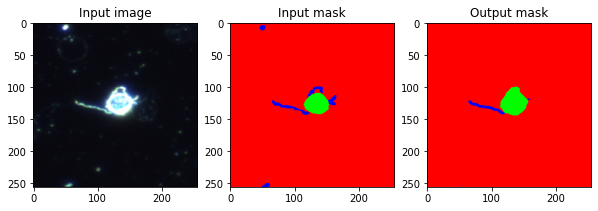

In [177]:
plot_results(test_img,test_mask,tf.squeeze(prediction))

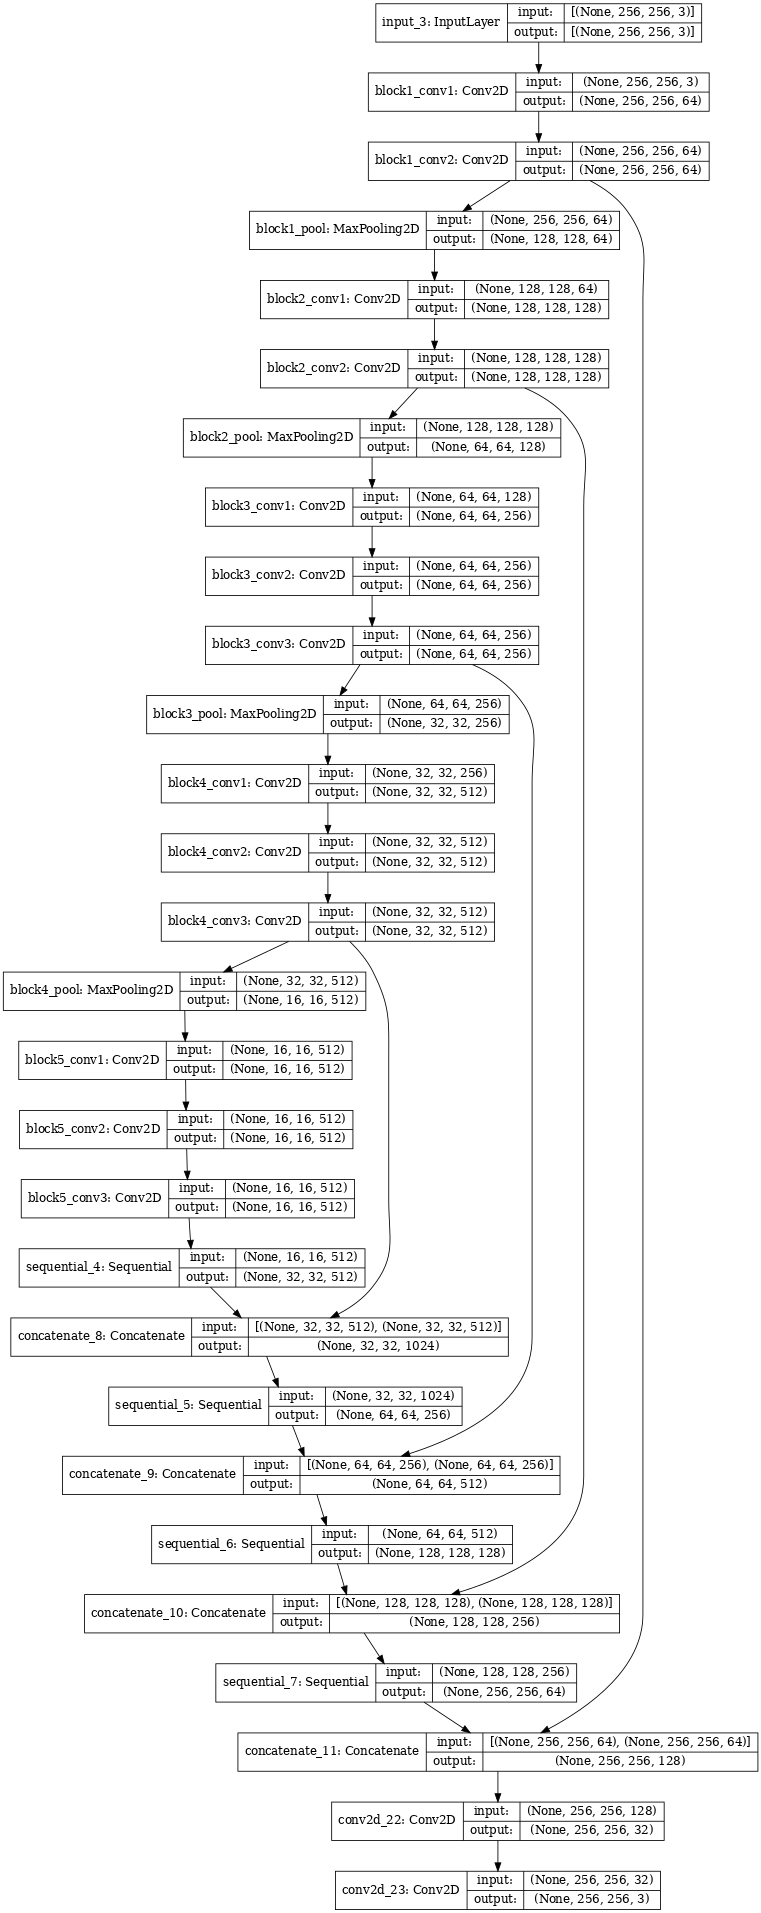

In [178]:
model_2 = unet_pretrained(number_of_classes=3,final_activation='softmax')
tf.keras.utils.plot_model(
    model_2,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [179]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss = tf.keras.losses.CategoricalCrossentropy(),metrics=[jaccard_coef])

In [180]:
early_stop_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience=20)
plat_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=10,factor = 0.00001)

In [181]:
history_2 = model_2.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=100,batch_size=16,callbacks=[early_stop_2,plat_2])

Epoch 1/100
20/20 [==============================] - 6s 245ms/step - loss: 0.8601 - jaccard_coef: 0.6846 - val_loss: 4.4872 - val_jaccard_coef: 0.1046
Epoch 2/100
20/20 [==============================] - 5s 226ms/step - loss: 0.2459 - jaccard_coef: 0.8685 - val_loss: 0.8820 - val_jaccard_coef: 0.6440
Epoch 3/100
20/20 [==============================] - 5s 234ms/step - loss: 0.1738 - jaccard_coef: 0.8952 - val_loss: 0.3391 - val_jaccard_coef: 0.8036
Epoch 4/100
20/20 [==============================] - 5s 226ms/step - loss: 0.1253 - jaccard_coef: 0.8843 - val_loss: 0.1817 - val_jaccard_coef: 0.8931
Epoch 5/100
20/20 [==============================] - 5s 226ms/step - loss: 0.1082 - jaccard_coef: 0.9054 - val_loss: 0.1657 - val_jaccard_coef: 0.8787
Epoch 6/100
20/20 [==============================] - 5s 226ms/step - loss: 0.0980 - jaccard_coef: 0.9068 - val_loss: 0.1704 - val_jaccard_coef: 0.8770
Epoch 7/100
20/20 [==============================] - 5s 227ms/step - loss: 0.0944 - jaccard_co

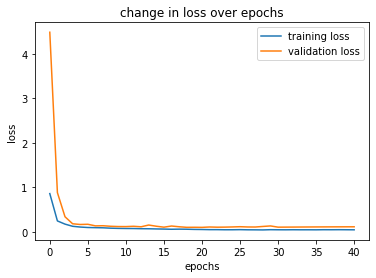

In [182]:
x = [i for i in range(len(history_2.history['loss']))]
plt.plot(x,history_2.history['loss'])
plt.plot(x,history_2.history['val_loss'])
plt.title('change in loss over epochs')
plt.legend(['training loss','validation loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

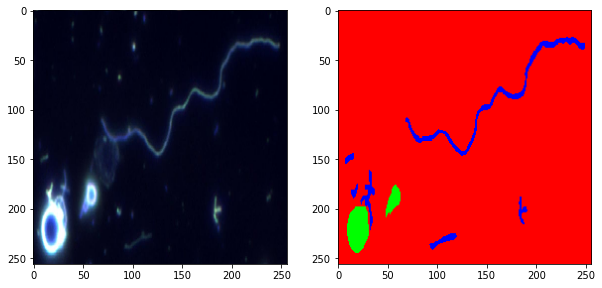

In [211]:

test_img = x_test[10]
test_mask = y_test[10]


f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(test_img)
f.add_subplot(1,2, 2)
plt.imshow(test_mask)


In [212]:
prediction = model_2.predict(tf.expand_dims(test_img,axis=0))

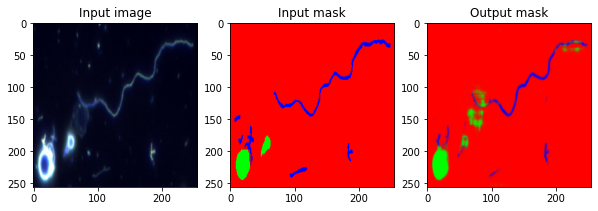

In [213]:
plot_results(test_img,test_mask,tf.squeeze(prediction))

In [137]:
tf.keras.backend.clear_session()

# Rezultati

BODY SEGMENTATION:

Možemo primetiti da oba modela imaju jako slične performanse (razlika od ~= 0.01 za funkciju gubitka na kraju perioda od 20 epoha),<br> ali kada koristimo vec istrenirane mreže brže konvergiramo u lokalni minimum (vec od 11-te epohe imamo jaccard loss od 0.90).<br>
Druga razlika je u tome da iako je preistrenirana mreža veća od mreže koju smo napravili od nule (20m parametara u odnosu na 8m), pošto smo zaledili slojeve u koderu (u fazi treniranja nećemo učiti parametre kodera), ona ima manje parametara koji se uče nego mreža koju smo napravili od nule(5m parametara u odnosu na 8m), stoga će vreme za izvršavanje jedne epohe biti kraće.

BACTERIA SEGMENTATION:

U ovom slučaju možemo primetiti da su rezultati treniranja preistrenirane mreže generalno lošiji od mreže koje smo trenirali od nule (iako je IOU relativno sličan, možemo da vidimo da naša mreža koju smo trenirali od nule bolje zaključuje granice objekata i dolazi do manje grešaka u predikciji samih klasa). Takodje kod preistreniranog modela postoji mogucnost da se model 'zaglavi', tj. od prve epohe dolazi do 0.79 jaccard lossa i tokom treniranja se ne menja, a kada se pogledaju rezultati možemo da vidimo da model u tom slučaju pravi masku koja koja ne sadrži nijedan objekat. Ovo se dešava ako koristimo jaccard loss kao funkciju gubitka. Takođe kod modela kojeg smo trenirali od nule se isto javljaju greške u klasifikaciji ali su one uglavnom greške u predviđanju klase dva čiji je procenat u čitavom datasetu mnogo manji od klase nula(pozadina) i klase jedan
